In [2]:
# 1. Measures of Similarity and Dissimilarity 
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

CSV_PATH = "./WineQT.csv"
df = pd.read_csv(CSV_PATH)

if 'Id' in df.columns or 'id' in df.columns:
    df = df.drop(columns=[c for c in df.columns if c.lower() == 'id'])

X = df.drop(columns=['quality']).select_dtypes(include=[np.number])
y_raw = df['quality'].values

# taking first 2 raws
a = X.iloc[0].values.astype(float)
b = X.iloc[1].values.astype(float)

# Euclid
euclid = np.linalg.norm(a - b)
print(f"Euclidean distance: {euclid:.4f}")

# Cos_sim
cos_sim = cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0,0]
print(f"Cosine similarity: {cos_sim:.4f}")

# Correlation
corr, pval = pearsonr(a, b)
print(f"Pearson correlation: {corr:.4f} (p={pval:.4g})")

# Jaccard 
X_bin = (X >= X.median()).astype(int)
a_bin = X_bin.iloc[0].values
b_bin = X_bin.iloc[1].values
intersection = np.logical_and(a_bin, b_bin).sum()
union = np.logical_or(a_bin, b_bin).sum()
jaccard = intersection / union
print(f"Jaccard similarity: {jaccard:.4f}")



Euclidean distance: 35.8602
Cosine similarity: 0.9866
Pearson correlation: 0.9854 (p=3.17e-08)
Jaccard similarity: 0.2500


Explained variance)(top 5): [0.2869 0.1708 0.1431 0.1101 0.0871]
Explained variance ratio (sklearn): [0.2869 0.1708]


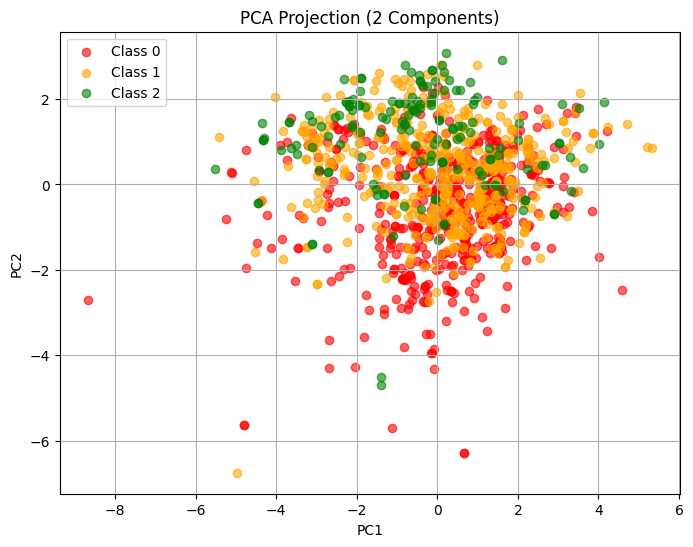

In [3]:
# 2. Dimensionality Reduction (PCA)
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA as SKPCA 

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Cov_mat
cov_matrix = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
idx = np.argsort(eig_vals)[::-1]
eig_vals_sorted = eig_vals[idx]
eig_vecs_sorted = eig_vecs[:, idx]
explained_variance_ratio = eig_vals_sorted / np.sum(eig_vals_sorted)
print("Explained variance)(top 5):", np.round(explained_variance_ratio[:5], 4))

# proection w 2 main components
W2 = eig_vecs_sorted[:, :2]
X_pca_manual = X_std.dot(W2)

# sklearn PCA for checking 
skpca = SKPCA(n_components=2)
X_pca_sklearn = skpca.fit_transform(X_std)
print("Explained variance ratio (sklearn):", np.round(skpca.explained_variance_ratio_, 4))

# visualization
plt.figure(figsize=(8, 6))
colors = ['red', 'orange', 'green']
def bin_quality(q):
    if q <= 5: return 0
    elif q == 6: return 1
    else: return 2
y_binned = np.array([bin_quality(q) for q in y_raw])
for cls, color in zip([0,1,2], colors):
    plt.scatter(X_pca_manual[y_binned==cls,0], X_pca_manual[y_binned==cls,1], c=color, label=f"Class {cls}", alpha=0.6)
plt.title("PCA Projection (2 Components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# 3. Supervised Machine Learning 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd 

X_train, X_test, y_train, y_test = train_test_split(
    X, y_binned, test_size=0.3, stratify=y_binned, random_state=42
)

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "kNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
}

results = {}
for name, model in models.items():
    # using scaled data
    if name == "Decision Tree":
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
    # metrics
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
# table of sum
print("\n=== Summary of Accuracies ===")
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
print(results_df.sort_values(by='Accuracy', ascending=False))


=== Logistic Regression ===
Accuracy: 0.6472
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       157
           1       0.58      0.57      0.57       138
           2       0.53      0.40      0.45        48

    accuracy                           0.65       343
   macro avg       0.61      0.59      0.59       343
weighted avg       0.64      0.65      0.64       343

Confusion Matrix:
[[125  29   3]
 [ 46  78  14]
 [  2  27  19]]

=== kNN (k=5) ===
Accuracy: 0.5773
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       157
           1       0.52      0.57      0.54       138
           2       0.44      0.38      0.40        48

    accuracy                           0.58       343
   macro avg       0.54      0.53      0.54       343
weighted avg       0.58      0.58      0.58       343

Confusion Matrix:
[[102  51   4]
 [ 41  78  19